# Charge and Isotope Deconvolution

A single mass spectrum contains measurements of one or more analytes and
the m/z values recorded for these analytes. Most analytes produce
multiple signals in the mass spectrometer, due to the natural abundance
of carbon $13$ (naturally occurring at ca. $1%$ frequency) and the large
amount of carbon atoms in most organic molecules, most analytes produce
a so-called isotopic pattern with a monoisotopic peak (all carbon are
`^{12}C`) and a first isotopic peak (exactly one carbon atom is a
`^{13}C`), a second isotopic peak (exactly two atoms are `^{13}C`) etc.
Note that also other elements can contribute to the isotope pattern, see
the [chemistry section](chemistry.ipynb) for further details.

In addition, each analyte may appear in more than one charge state and
adduct state, a singly charge analyte `[M +H]+` may be accompanied by a
doubly charged analyte `[M +2H]++` or a sodium adduct `[M +Na]+`. In the
case of a multiply charged peptide, the isotopic traces are spaced by
`PROTON_MASS / charge_state` which is often close to $0.5\ m/z$ for
doubly charged analytes, $0.33\ m/z$ for triply charged analytes etc.
Note: tryptic peptides often appear at least doubly charged, while small
molecules often carry a single charge but can have adducts other than
hydrogen.

## Single Peak Example

In [ ]:
import pyopenms as oms

charge = 2
seq = oms.AASequence.fromString("DFPIANGER")
seq_formula = seq.getFormula() + oms.EmpiricalFormula("H" + str(charge))
isotopes = seq_formula.getIsotopeDistribution(oms.CoarseIsotopePatternGenerator(6))
print("[M+H]+ weight:", seq.getMonoWeight(oms.Residue.ResidueType.Full, 1))

# Append isotopic distribution to spectrum
s = oms.MSSpectrum()
for iso in isotopes.getContainer():
    iso.setMZ(iso.getMZ() / charge)
    s.push_back(iso)
    print("Isotope", iso.getMZ(), ":", iso.getIntensity())

oms.Deisotoper.deisotopeAndSingleChargeDefault(s, 10, True)

for p in s:
    print(p.getMZ(), p.getIntensity())

Note that the algorithm presented here as some heuristics built into it,
such as assuming that the isotopic peaks will decrease after the first
isotopic peak. This heuristic can be tuned by changing the parameter
`use_decreasing_model` and `start_intensity_check`. In this case, the
second isotopic peak is the highest in intensity and the
`start_intensity_check` parameter needs to be set to 3.

In [ ]:
charge = 4
seq = oms.AASequence.fromString("DFPIANGERDFPIANGERDFPIANGERDFPIANGER")
seq_formula = seq.getFormula() + oms.EmpiricalFormula("H" + str(charge))
isotopes = seq_formula.getIsotopeDistribution(oms.CoarseIsotopePatternGenerator(8))
print("[M+H]+ weight:", seq.getMonoWeight(oms.Residue.ResidueType.Full, 1))

# Append isotopic distribution to spectrum
s = oms.MSSpectrum()
for iso in isotopes.getContainer():
    iso.setMZ(iso.getMZ() / charge)
    s.push_back(iso)
    print("Isotope", iso.getMZ(), ":", iso.getIntensity())

min_charge = 1
min_isotopes = 2
max_isotopes = 10
use_decreasing_model = True
start_intensity_check = 3
oms.Deisotoper.deisotopeAndSingleCharge(
    s,
    10,
    True,
    min_charge,
    charge,
    True,
    min_isotopes,
    max_isotopes,
    True,
    True,
    True,
    use_decreasing_model,
    start_intensity_check,
    False,
)
for p in s:
    print(p.getMZ(), p.getIntensity())

## Full Spectral De-Isotoping

In the following code segment, we will use a sample measurement of BSA
(Bovine Serum Albumin), and apply a simple algorithm in OpenMS for
"deisotoping" a mass spectrum, which means grouping peaks of the same
isotopic pattern charge state:

In [ ]:
from urllib.request import urlretrieve

gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-docs/master"
urlretrieve(gh + "/src/data/BSA1.mzML", "BSA1.mzML")

e = oms.MSExperiment()
oms.MzMLFile().load("BSA1.mzML", e)
s = e[214]
s.setFloatDataArrays([])
oms.Deisotoper.deisotopeAndSingleCharge(
    s,
    0.1,
    False,
    1,
    3,
    True,
    min_isotopes,
    max_isotopes,
    True,
    True,
    True,
    use_decreasing_model,
    start_intensity_check,
    False,
)

print(e[214].size())
print(s.size())

e2 = oms.MSExperiment()
e2.addSpectrum(e[214])
oms.MzMLFile().store("BSA1_scan214_full.mzML", e2)
e2 = oms.MSExperiment()
e2.addSpectrum(s)
oms.MzMLFile().store("BSA1_scan214_deisotoped.mzML", e2)

maxvalue = max([p.getIntensity() for p in s])
for p in s:
    if p.getIntensity() > 0.25 * maxvalue:
        print(p.getMZ(), p.getIntensity())

which produces the following output

``` output
140
41

974.4572680576728 6200571.5
974.4589691256419 3215808.75
```

As we can see, the algorithm has reduced $140$ peaks to $41$ deisotoped
peaks. It also has identified a molecule at $974.45\ m/z$ as the most
intense peak in the data (base peak).

## Visualization

The reason we see two peaks very close together becomes apparent once we
look at the data in
[TOPPView](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-TOPPView)
which indicates that the $974.4572680576728$ peak is derived from a `2+`
peak at m/z $487.73$ and the peak at $974.4589691256419$ is derived from
a `3+` peak at m/z $325.49$: the algorithm has identified a single
analyte in two charge states and deconvoluted the peaks to their nominal
mass of a `[M +H]+` ion, which produces two peaks very close together
(`2+` and `3+` peak):

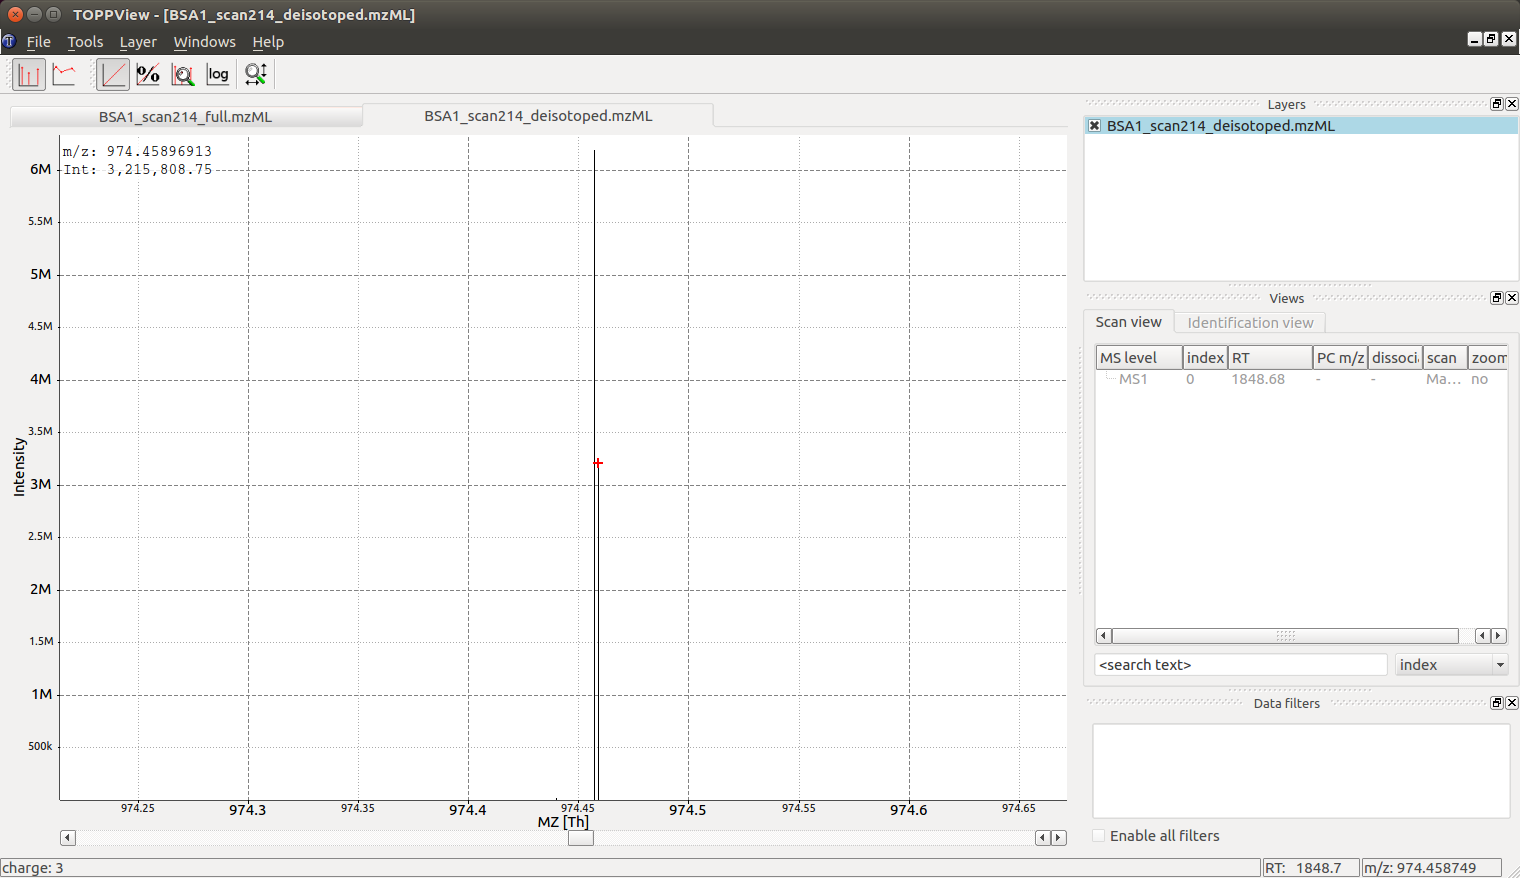

Looking at the full mass spectrum and comparing it to the original mass
spectrum, we can see the original (centroided) mass spectrum on the top
and the deisotoped mass spectrum on the bottom in blue. Note how
hovering over a peak in the deisotoped mass spectrum indicates the
charge state:

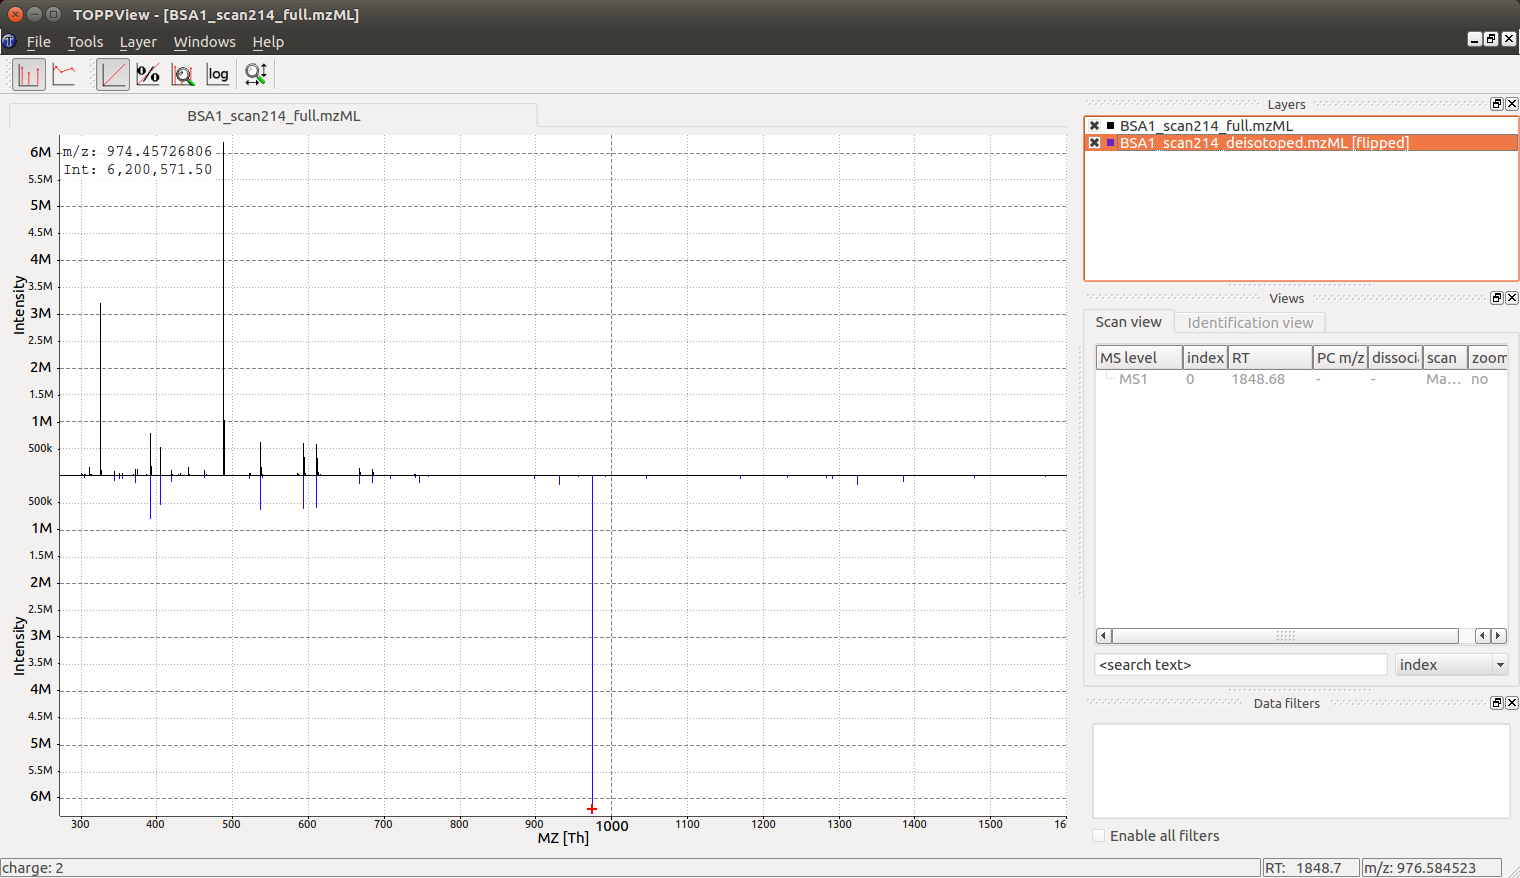

In the next section ([Feature Detection](feature_detection.ipynb)), we
will look at 2-dimensional deisotoping where instead of a single mass
spectrum, multiple mass spectra from a
[LC-MS](https://pyopenms.readthedocs.io/en/latest/user_guide/glossary.html#term-LC-MS)
experiment are analyzed together. There algorithms analyze the full
2-dimensional (m/z and RT) signal and are generally more powerful than
the 1-dimensional algorithm discussed here. However, not all data is 2
dimensional and the algorithm discussed here has many application in
practice (e.g. single mass spectra, fragment ion mass spectra in DDA
etc.).